# Largest Island

---

## 1. **Mail Fraud / Counterfeit Clusters**

* **Problem:** USPS runs address–to–transaction–to–package graphs. Fraud rings operate by spreading counterfeit shipments across many addresses, then recombining them.
* **Island analog:** Given a binary grid where `1 = suspicious transaction`, the largest island = biggest fraud cell.
* **Why it matters:** You'll know how to detect and bound “largest connected suspicious subnet.” In practice, this means clustering counterfeit detection anomalies without requiring an off-the-shelf ML model.

---

## 2. **Network Outages & Routing Black Spots**

* **Problem:** USPS has \~30k facilities and routes. If a sorting center goes offline (weather, cyber, mechanical), you need to identify **largest contiguous region** of the network impacted.
* **Island analog:** In a grid/graph, `0 = outage, 1 = healthy`, flip one `0` to `1` → what’s the biggest functional cluster you can restore?
* **Why it matters:** They test if you can quickly reason about resilience, failover, and which single node/edge restoration maximizes throughput. That’s exactly “make the largest island.”

---

## 3. **Carrier Coverage Optimization**

* **Problem:** Carriers’ routes are essentially grid graphs. If you remove one road/segment, what’s the largest reachable subgraph of households? Or, conversely, if you add one street to coverage, what’s the maximum contiguous service area gained?
* **Island analog:** Same as LeetCode #827: flip one “0” (new street/connection) → find maximum contiguous connected component (largest service area).
* **Why it matters:** You'll think like an ops scientist, turning route coverage into adjacency logic, and you can quantify efficiency gains with one small intervention.

---


In [10]:
from typing import List

class Solution:
    def largestIsland(self, grid: List[List[int]]) -> int:
        n = len(grid)
        if n == 0:
            return 0   # guard against empty grid

        # -----------------------------
        # helper: check if (r,c) is inside the grid
        def inb(r: int, c: int) -> bool:
            return 0 <= r < n and 0 <= c < n

        # -----------------------------
        # Step 1) Label every island with a unique id >= 2
        #   (we overwrite 1's with label numbers so we can later identify them)
        #   sizes[label] = area of that island
        label = 2
        sizes = {0: 0}  # treat water lookups as size 0, avoids KeyError later

        # depth-first search (iterative stack) to flood-fill an island
        def dfs_label(sr: int, sc: int, lbl: int) -> int:
            stack = [(sr, sc)]         # start at one land cell
            grid[sr][sc] = lbl         # overwrite that cell with its label
            area = 1                   # area counter for this island
            while stack:
                r, c = stack.pop()
                # look at four neighbors
                for nr, nc in ((r+1, c), (r-1, c), (r, c+1), (r, c-1)):
                    if inb(nr, nc) and grid[nr][nc] == 1:
                        # if neighbor is still unvisited land, label it
                        grid[nr][nc] = lbl
                        area += 1
                        stack.append((nr, nc))
            return area                # return total island size

        # loop over all cells and label each island
        for r in range(n):
            for c in range(n):
                if grid[r][c] == 1:              # unvisited land cell
                    sizes[label] = dfs_label(r, c, label)
                    label += 1                   # next island gets new label

        # -----------------------------
        # Edge case: if grid has no zeros, i.e. all land, return n*n
        if all(grid[r][c] != 0 for r in range(n) for c in range(n)):
            return n * n

        # -----------------------------
        # Step 2) For each zero cell, simulate flipping it to 1.
        #   Look at all distinct neighboring island labels,
        #   sum their sizes + 1 for this flipped cell,
        #   keep the maximum.
        best = 0
        for r in range(n):
            for c in range(n):
                if grid[r][c] == 0:  # candidate flip
                    seen = set()     # to avoid double-counting same island
                    total = 1        # the flipped cell itself counts as 1
                    for nr, nc in ((r+1, c), (r-1, c), (r, c+1), (r, c-1)):
                        if inb(nr, nc):
                            lbl = grid[nr][nc]
                            # if it's a labeled island we haven't added yet
                            if lbl > 1 and lbl not in seen:
                                total += sizes[lbl]   # add its size
                                seen.add(lbl)
                    best = max(best, total)  # update maximum possible island

        # -----------------------------
        # Edge case: if original grid was all water,
        # best stays 0 but flipping one cell yields island of size 1
        return max(best, 1)
    
    
# -----------------------------
# Test Example (10x10 grid)
grid = [
 [1,0,0,1,0,0,1,1,0,0],
 [1,1,0,1,0,0,1,0,0,0],
 [0,1,0,0,0,1,1,0,1,0],
 [0,0,0,0,0,1,0,0,1,1],
 [1,1,0,0,0,0,0,0,0,1],
 [1,0,0,1,1,1,0,0,0,0],
 [0,0,0,0,0,1,0,1,1,0],
 [0,1,1,1,0,0,0,1,0,0],
 [0,0,0,1,1,1,0,0,0,0],
 [0,0,0,0,0,1,1,0,0,0],
]

print(Solution().largestIsland(grid))


13


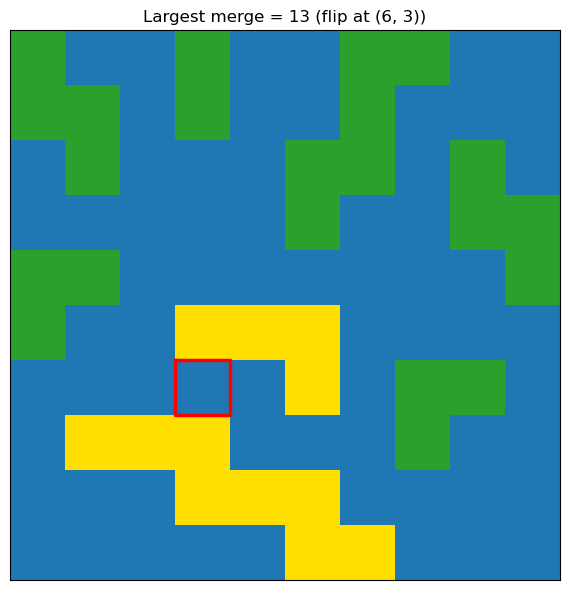

In [14]:
from typing import List, Tuple, Dict
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Single-pass: label islands, compute best flip, and visualize (no duplicate work)
def largest_island_and_plot(grid: List[List[int]]) -> int:
    A = np.array(grid, dtype=int)
    n = A.shape[0]
    labels = A.copy()
    label = 2
    sizes: Dict[int, int] = {0: 0}

    def inb(r: int, c: int) -> bool:
        return 0 <= r < n and 0 <= c < n

    def dfs_label(sr: int, sc: int, lbl: int) -> int:
        stack = [(sr, sc)]
        labels[sr, sc] = lbl
        area = 1
        while stack:
            r, c = stack.pop()
            for nr, nc in ((r+1,c),(r-1,c),(r,c+1),(r,c-1)):
                if inb(nr,nc) and labels[nr,nc] == 1:
                    labels[nr,nc] = lbl
                    area += 1
                    stack.append((nr,nc))
        return area

    # Label once + record sizes
    for r in range(n):
        for c in range(n):
            if labels[r,c] == 1:
                sizes[label] = dfs_label(r, c, label)
                label += 1

    # If already all land
    if np.all(labels > 0):
        best_total, best_cell, best_neighbors = n*n, None, set()
    else:
        # Best flip using the labeled grid
        best_total = 0
        best_cell: Tuple[int,int] | None = None
        best_neighbors = set()
        for r in range(n):
            for c in range(n):
                if labels[r,c] == 0:
                    seen, total = set(), 1
                    for nr, nc in ((r+1,c),(r-1,c),(r,c+1),(r,c-1)):
                        if inb(nr,nc):
                            lblv = labels[nr,nc]
                            if lblv > 1 and lblv not in seen:
                                total += sizes[lblv]
                                seen.add(lblv)
                    if total > best_total:
                        best_total, best_cell, best_neighbors = total, (r,c), seen
        best_total = max(best_total, 1)

    # Build one composite map for visualization
    # 0=water(blue), 1=land(green), 2=merged islands after best flip (yellow)
    composite = np.where(labels > 1, 1, 0)
    if best_neighbors:
        merged_mask = np.isin(labels, np.fromiter(best_neighbors, dtype=int))
        composite[merged_mask] = 2

    # Plot once
    cmap = ListedColormap(["#1f77b4", "#2ca02c", "#ffdf00"])
    plt.figure(figsize=(6,6))
    plt.imshow(composite, origin='upper', interpolation='nearest', cmap=cmap, vmin=0, vmax=2)
    plt.xticks([]); plt.yticks([])
    if best_cell is not None:
        r, c = best_cell
        plt.plot([c-0.5, c+0.5, c+0.5, c-0.5, c-0.5],
                 [r-0.5, r-0.5, r+0.5, r+0.5, r-0.5],
                 color='red', linewidth=2.5)
    plt.title(f"Largest merge = {best_total}" + (f" (flip at {best_cell})" if best_cell else ""))
    plt.tight_layout()
    plt.show()

    return best_total

# --------- Example run (single pass) ----------
grid = [
 [1,0,0,1,0,0,1,1,0,0],
 [1,1,0,1,0,0,1,0,0,0],
 [0,1,0,0,0,1,1,0,1,0],
 [0,0,0,0,0,1,0,0,1,1],
 [1,1,0,0,0,0,0,0,0,1],
 [1,0,0,1,1,1,0,0,0,0],
 [0,0,0,0,0,1,0,1,1,0],
 [0,1,1,1,0,0,0,1,0,0],
 [0,0,0,1,1,1,0,0,0,0],
 [0,0,0,0,0,1,1,0,0,0],
]

_ = largest_island_and_plot(grid)


# Bare-Bones

1. Label each island with unique ID (≥2) using DFS; store island sizes.  
2. If grid is all land → return n*n.  
3. For each water cell:  
      a) Look at its 4 neighbors.  
      b) Collect unique island IDs and sum their sizes + 1.  
      c) Track the maximum such total.  
4. Return max(best, 1).  


In [8]:
from typing import List

class Solution:
    def largestIsland(self, grid: List[List[int]]) -> int:
        n = len(grid)
        if n == 0:
            return 0

        def inb(r, c):
            return 0 <= r < n and 0 <= c < n

        label = 2
        sizes = {0: 0}

        def dfs_label(sr, sc, lbl):
            stack = [(sr, sc)]
            grid[sr][sc] = lbl
            area = 1
            while stack:
                r, c = stack.pop()
                for nr, nc in ((r+1, c), (r-1, c), (r, c+1), (r, c-1)):
                    if inb(nr, nc) and grid[nr][nc] == 1:
                        grid[nr][nc] = lbl
                        area += 1
                        stack.append((nr, nc))
            return area

        for r in range(n):
            for c in range(n):
                if grid[r][c] == 1:
                    sizes[label] = dfs_label(r, c, label)
                    label += 1

        if all(grid[r][c] != 0 for r in range(n) for c in range(n)):
            return n * n

        best = 0
        for r in range(n):
            for c in range(n):
                if grid[r][c] == 0:
                    seen = set()
                    total = 1
                    for nr, nc in ((r+1, c), (r-1, c), (r, c+1), (r, c-1)):
                        if inb(nr, nc):
                            lbl = grid[nr][nc]
                            if lbl > 1 and lbl not in seen:
                                total += sizes[lbl]
                                seen.add(lbl)
                    best = max(best, total)
        return max(best, 1)
